In [ ]:
import numpy as np
import pandas as pd
import pickle

In [ ]:
data = pickle.load(open('../data/60_second_data.p','rb'))

In [ ]:
from hrvanalysis import get_time_domain_features
from joblib import Parallel,delayed

In [36]:
def get_data(a):
    features = []
    ecg_rr = a[:,-1]
    ecg_rr = ecg_rr[~np.isnan(ecg_rr)]
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
        index = ppg_rr>0
        ppg_qual = ppg_qual[index]
        ppg_rr = ppg_rr[index]
        index = ~np.isnan(ppg_rr)
        ppg_qual = ppg_qual[index]
        ppg_rr = ppg_rr[index]
        if len(ppg_rr)<10:
            continue
        for i in np.linspace(0,.9,9):
            index = ppg_qual>i
            ppg_qual = ppg_qual[index]
            ppg_rr = ppg_rr[index]
            if len(ppg_rr)<10:
                continue
            f = list(get_time_domain_features(ppg_rr).values())
            f1 = list(get_time_domain_features(ecg_rr).values())
            q = [np.percentile(ppg_qual,20),np.mean(ppg_qual),len(ppg_rr)/60]
            features.append(np.array(f1+f+q))
    return np.array(features).reshape(-1,35)

df_col = Parallel(n_jobs=10,verbose=1)(delayed(get_data)(a) for a in data if len(a[~np.isnan(a[:,-1]),-1])>20)    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2880 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done 4316 out of 4316 | elapsed:    5.1s finished


In [37]:
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
quality_col = ['min','mean']
X = np.concatenate(df_col,axis=0)
X.shape

(25793, 35)

In [38]:
quality = X[:,-3:]
features = X[:,16:-3]
features_ecg = X[:,:16]

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
%matplotlib inline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
def aic(X,y):
    regr = OLS(y, add_constant(X)).fit()
    return regr.aic

# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100

def output(quality,features_ecg,features1,j,q_name):
    
    for i,f_name in enumerate(feature_col):
        features = features1[:,i]
        ground_truth = features_ecg[:,i]
        qual = quality[:,j]
#         output(quals,input_ecg,input_ppg,f_name,q_name)
    
        l_range = np.arange(0,1,.1)
        x = []
        y = []
        for l in l_range:
            index = np.where((qual>=l)&(qual<l+.1))[0]
            if len(index)<2:
                continue
            temp_input = features[index]
            temp_output = ground_truth[index]
            x.append(l)
    #         y.append(aic(temp_input,temp_output))
            y.append(mean_absolute_percentage_error(temp_output,temp_input))
    #     plt.boxplot(y,showfliers=False)
        plt.figure(figsize=(10,8))
        plt.rcParams.update({'font.size':20})
        plt.plot(x,y,label = str(f_name) )
    #     plt.xticks(range(1,len(x)+1),x,rotation=60)
        plt.ylabel('Percentage Error')
        plt.xlabel('Range of Signal Quality-'+str(q_name))
        plt.tight_layout()
        plt.legend()
        plt.show()



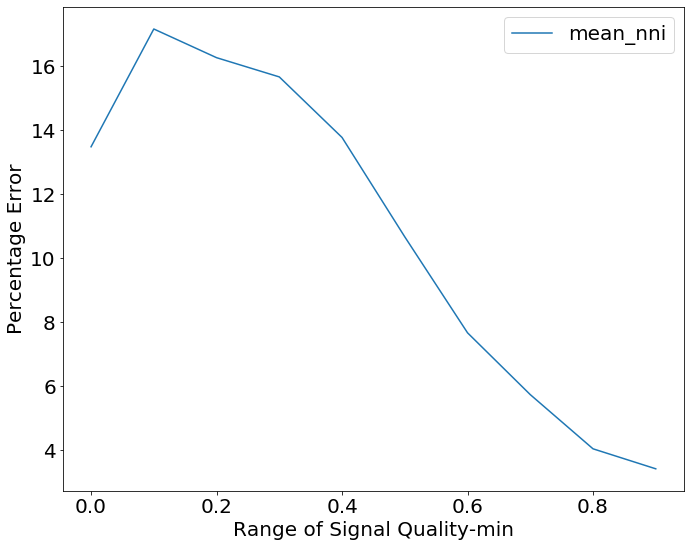

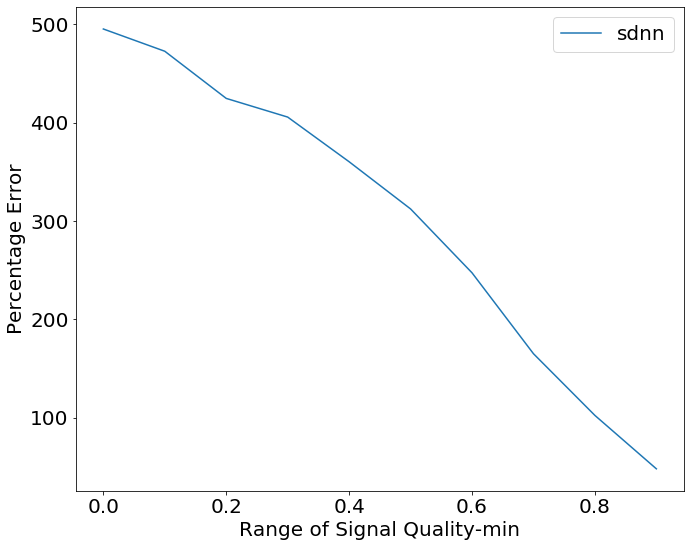

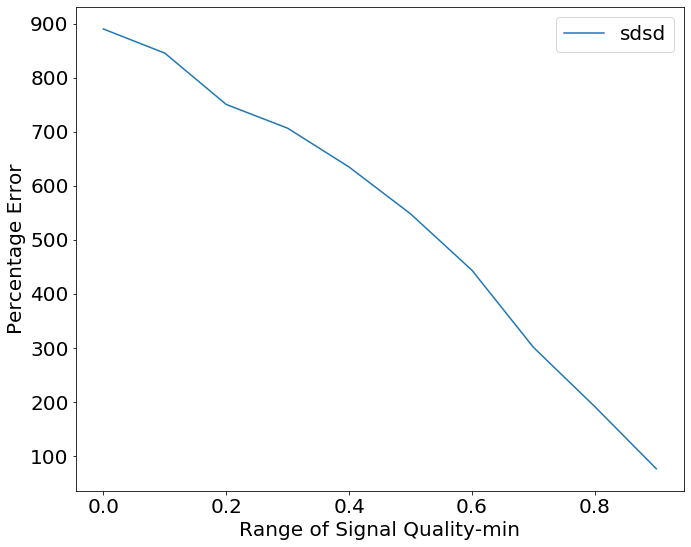

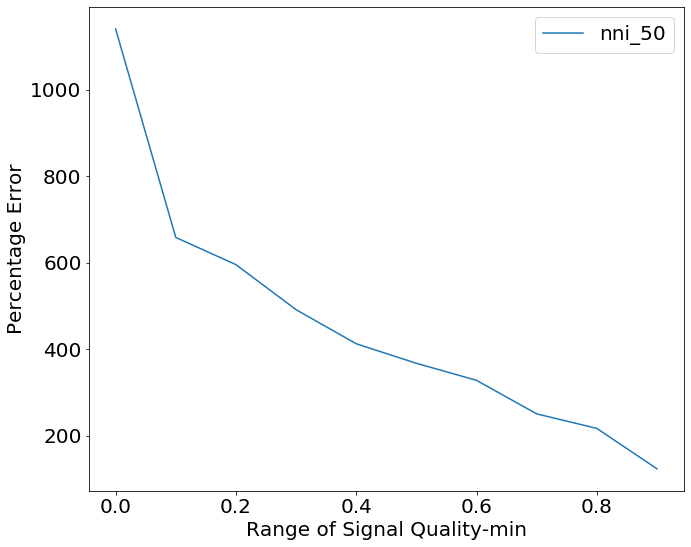

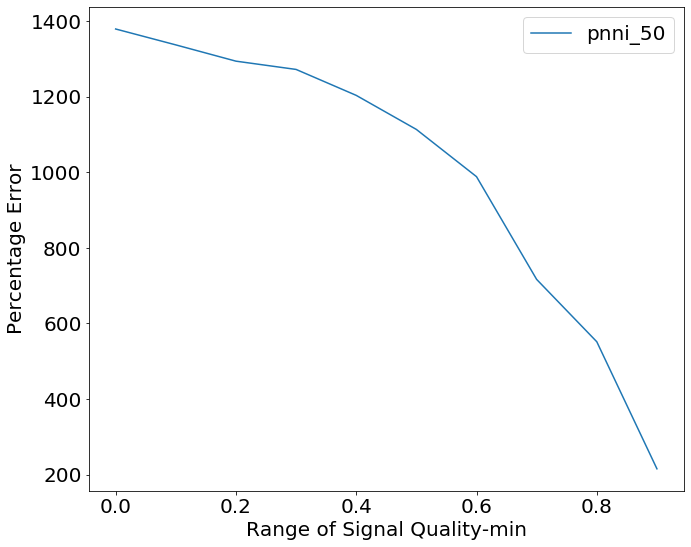

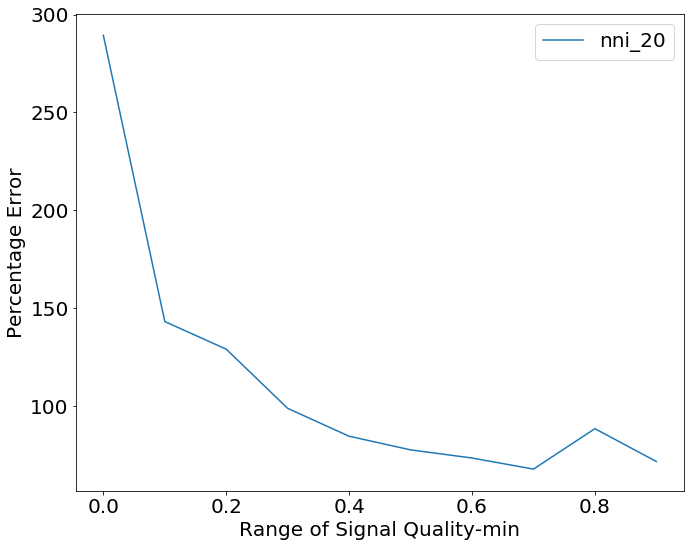

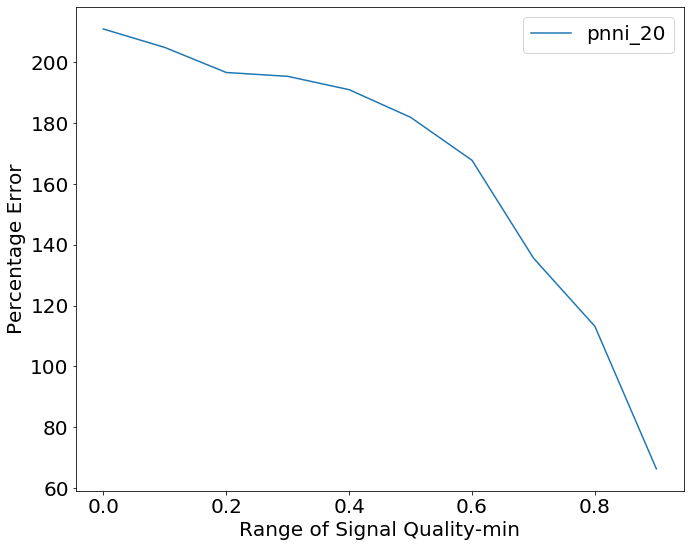

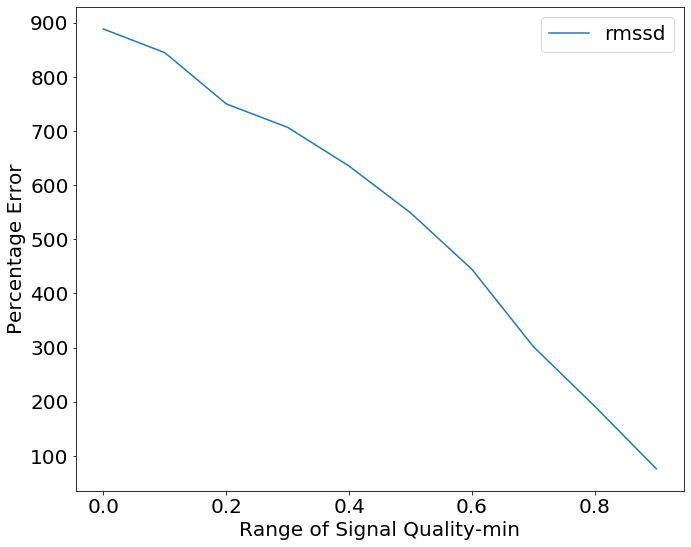

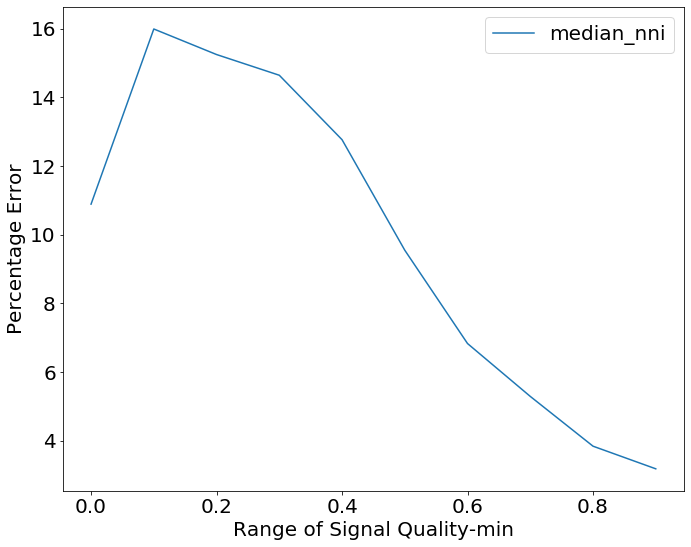

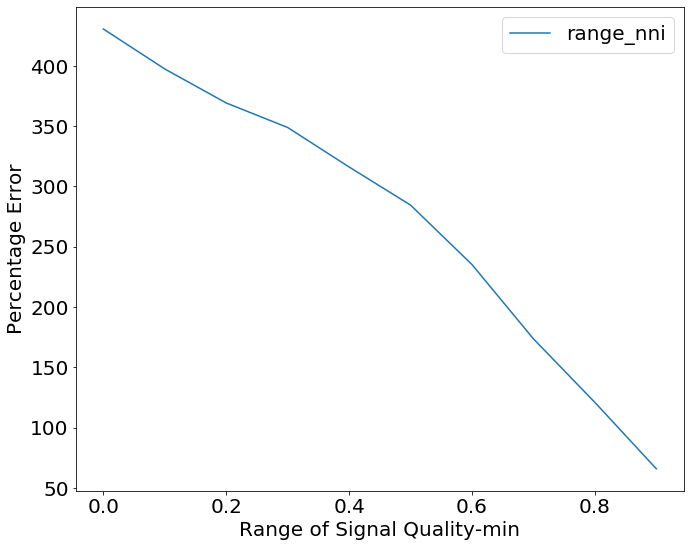

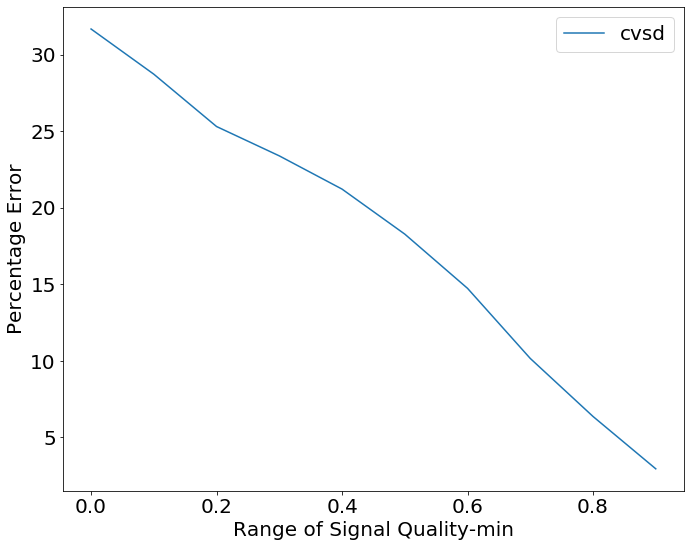

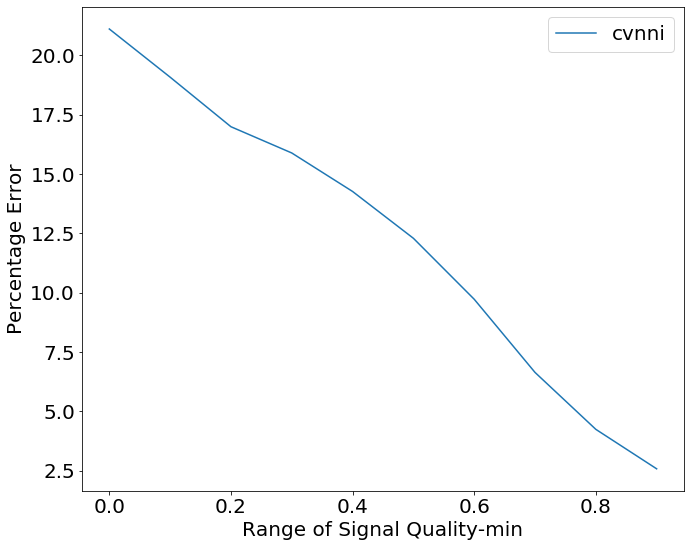

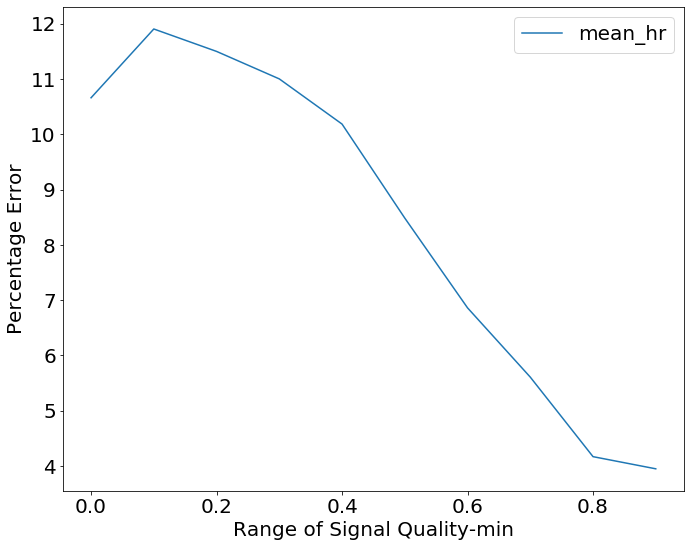

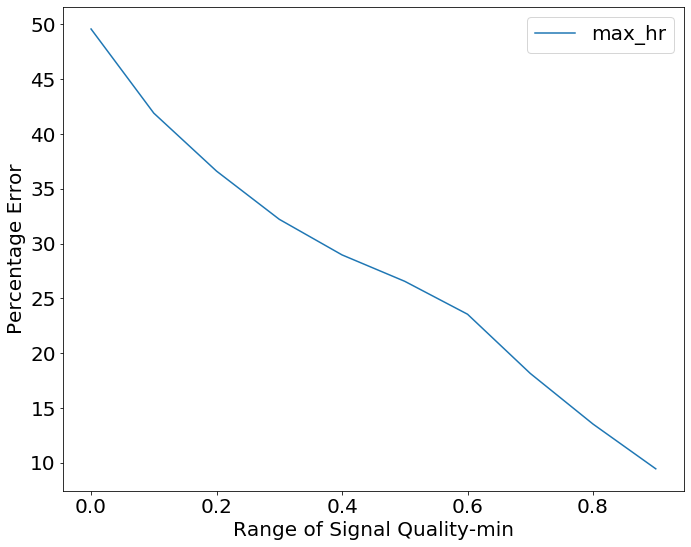

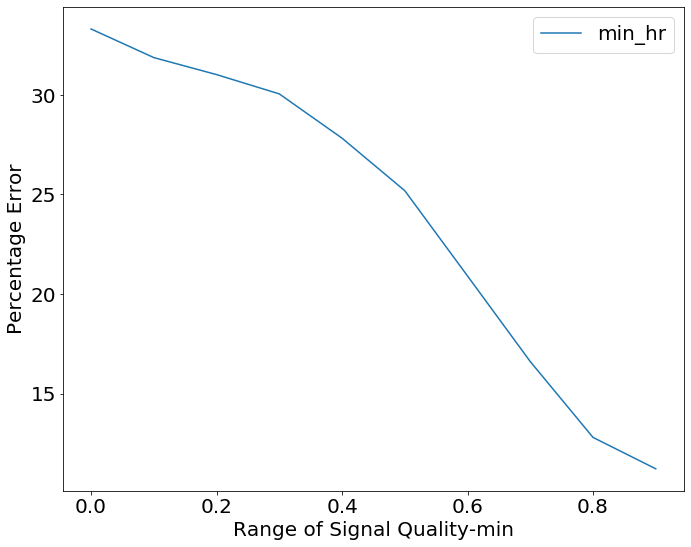

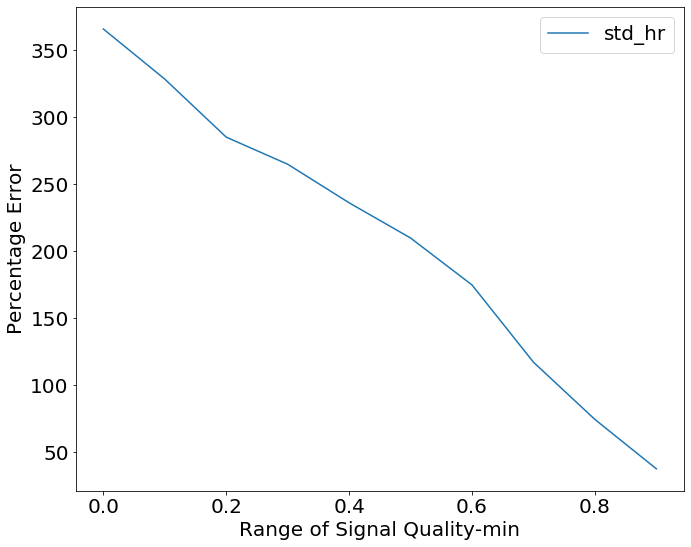

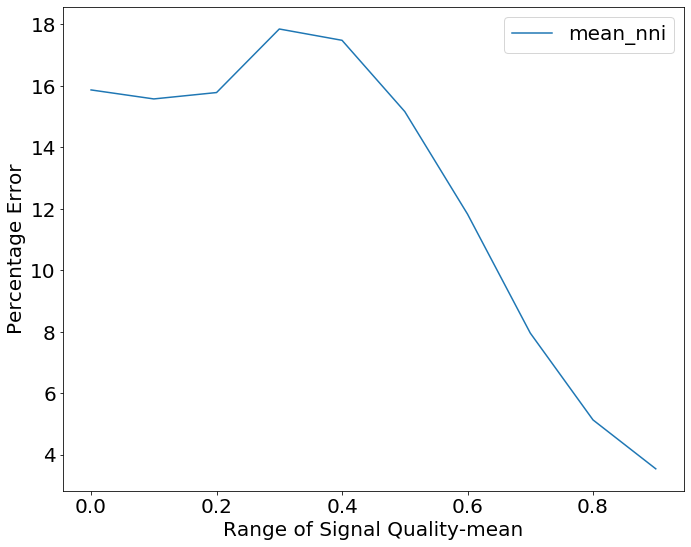

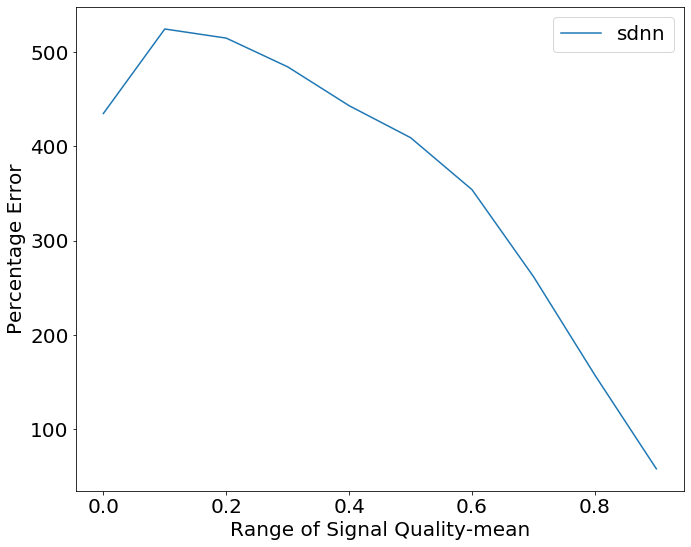

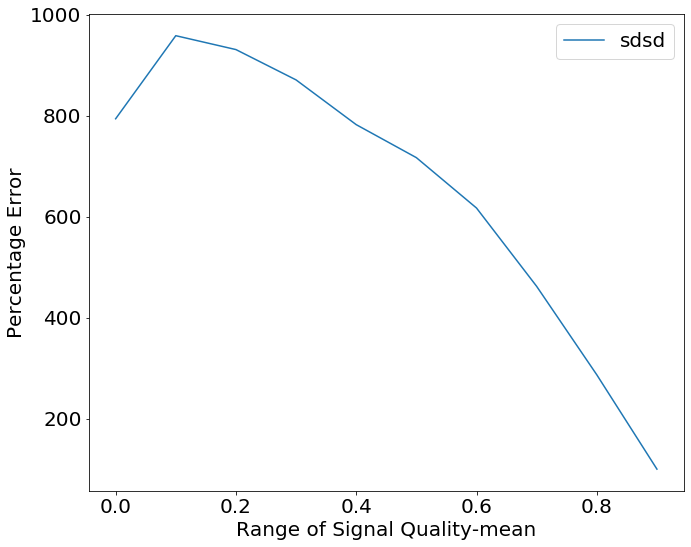

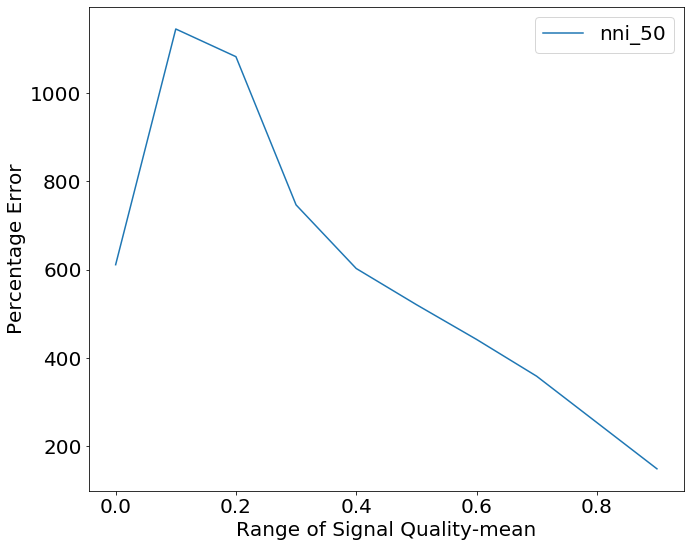

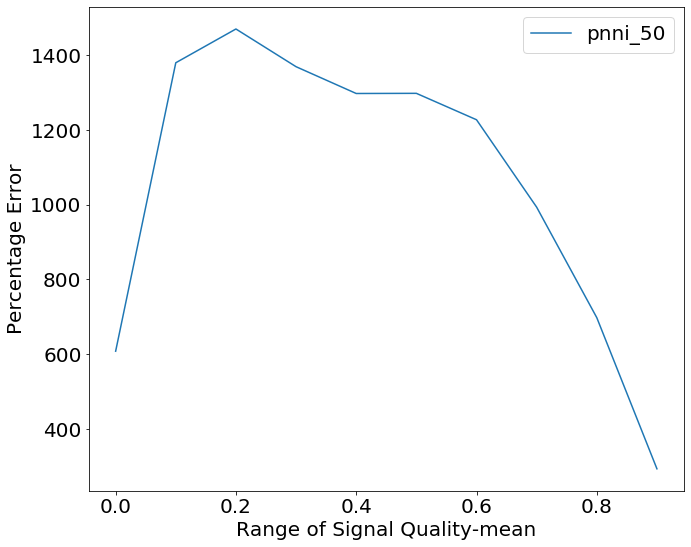

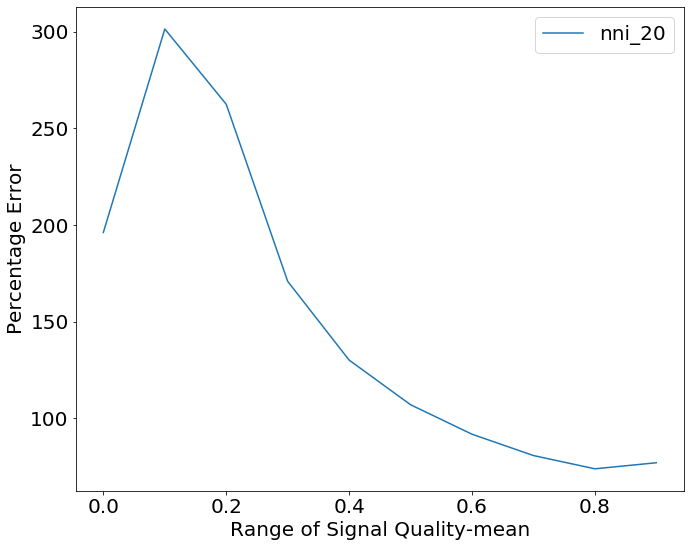

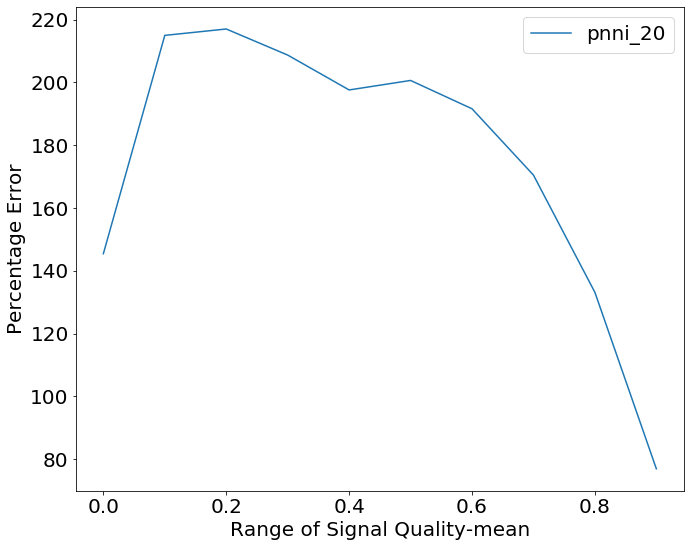

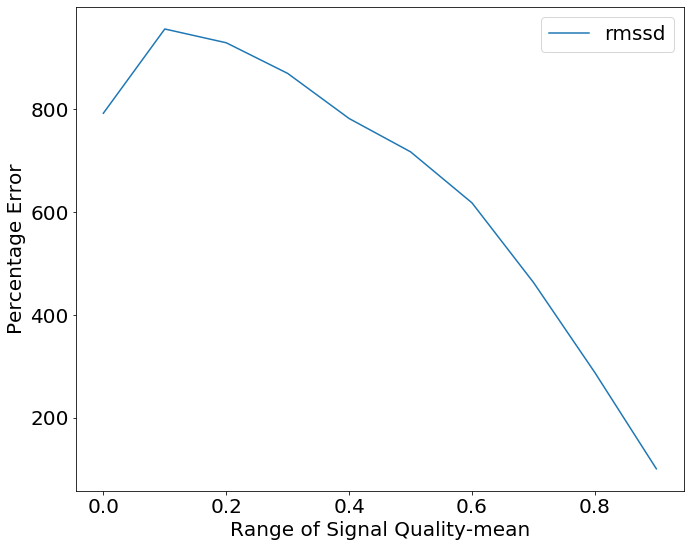

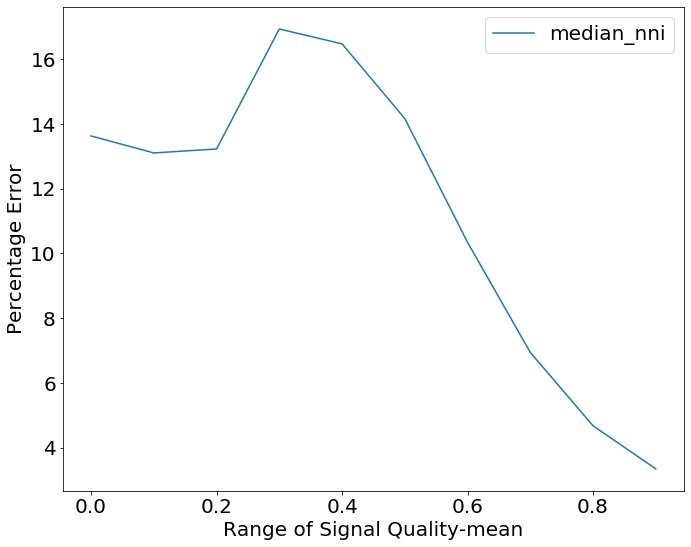

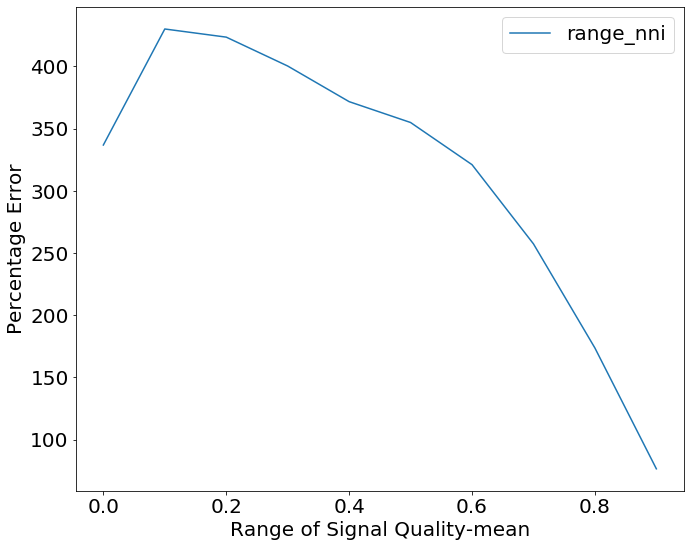

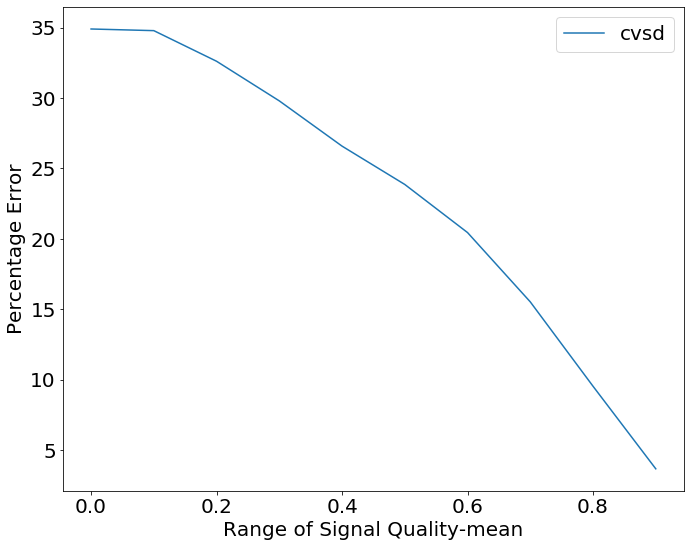

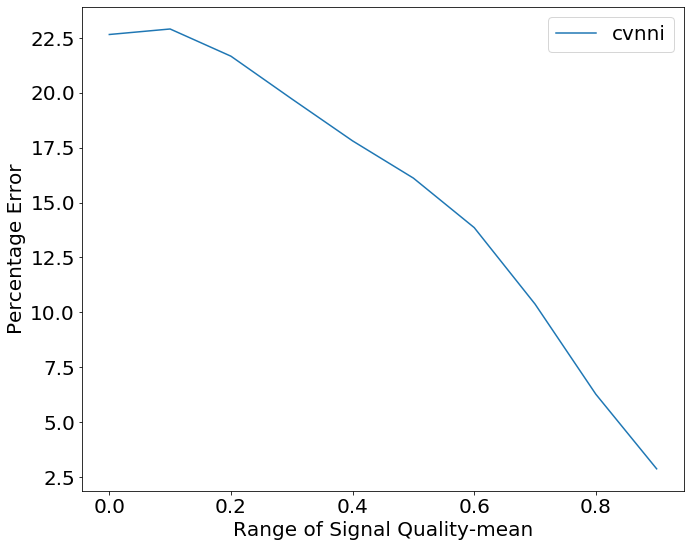

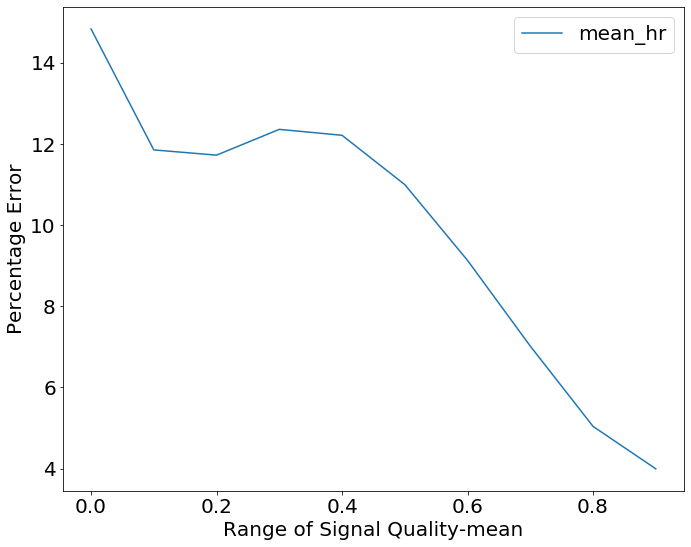

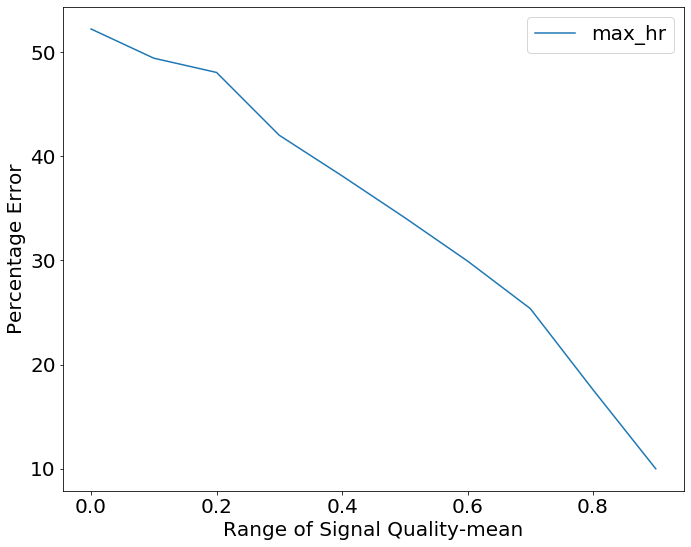

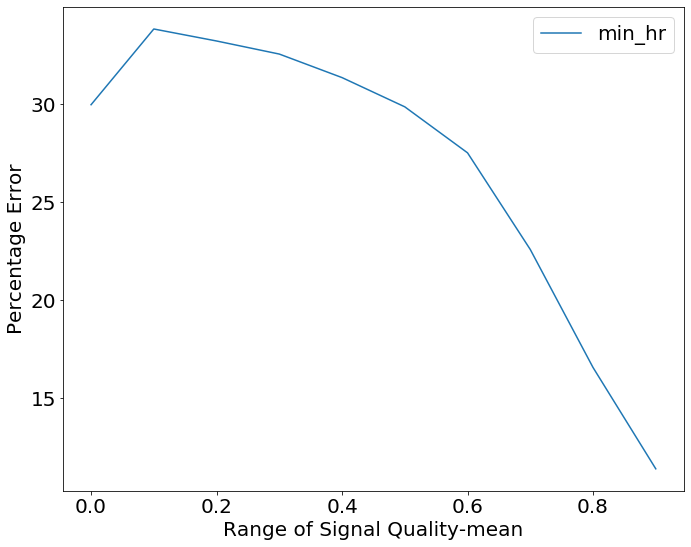

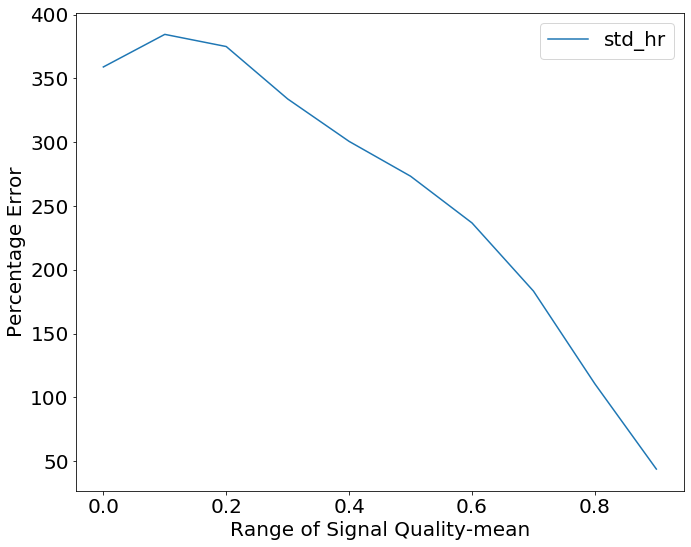

In [50]:
for j,q_name in enumerate(quality_col):
    output(quality,features_ecg,features,j,q_name)